Utils

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.stats as stats

import scipy
import pywt
import mne
from mne.decoding import CSP
import math

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, LeaveOneGroupOut

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder


from mne.time_frequency import AverageTFRArray

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
from stats_utils import *
import glob
import os

from mne.time_frequency import AverageTFRArray
import seaborn as sns
import warnings

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

#warnings and logs
warnings.simplefilter(action='ignore', category=FutureWarning)
mne.set_log_level('CRITICAL') #'INFO' for more detail, 'CRITICAL' for smaller output


In [3]:
def get_xy_filtered(file, label, filter = True, drop_bads = True, **kwargs):
    """
    gets the X data and y labels from an epochs object.
    sub: string e.g. '01'

    ---
    returns:
    X: epochs data of shape n_trials x n_channels (64 eeg channels) x n_times
    y: labels of size n_trials. Typically 1 for pre and 2 for post.
    """

    eps = mne.read_epochs(file)

    #drop bad epochs
    if drop_bads:
        drop_bads_kwargs = {key: value for key, value in kwargs.items() if key in ['reject', 'flat']}
        eps.drop_bad(**drop_bads_kwargs)  # Only pass relevant kwargs

        

    if filter:
        eps_filt = eps.copy()
        filter_kwargs = {key: value for key, value in kwargs.items() if key in ['l_freq', 'h_freq', 'method', 'iir_params']}
        eps_filt.filter(**filter_kwargs) 
        x = eps_filt.get_data()[:,:64, :]
        print(f'Bandpass filtering {file}')
        #mne.viz.plot_epochs_image(eps_filt, combine = 'mean')
    else:
        x = eps.get_data()[:, :64, :] #get eeg channels only
    
    #label array
    y = np.full_like(x[:,0,0], label)

    return x, y
   

   
def ep_PCA(epochs_data, n_components):
    """ 
    Performs PCA on epochs
    epochs_data: n_trials x n_channels x n_times
    ---
    Returns
    X_reconstructed: the PCA transformation that is projected back to channel space (64 channels)
    
    """
    pca = UnsupervisedSpatialFilter(PCA(n_components), average=False)
    X_pca = pca.fit_transform(epochs_data)


    #reconstruct PCA into EEG channel space
    #X_reconstructed = np.empty_like(X)  # Placeholder for reconstructed data
    X_reconstructed = pca.inverse_transform(X_pca)
    return X_reconstructed, X_pca

Parameters

In [4]:
#subject parameters
sub = '17'

ep_file_pre = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_{sub}.fif'
ep_file_post = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_{sub}.fif'
epochs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/'

#epochs parameters
iir_params = dict(order=8, ftype="butter") #for filtering frequencies
reject_criteria = dict(eeg=100e-6) 

# PIPELINE PARAMETERS
n_PCA = 4 #components of PCA to keep
n_CSP = 4 #components of CSP to keep
n_splits = 10  # for cross-validation, 5 is better, here we use 3 for speed


# Assemble the classifier using scikit-learn pipeline
clf = make_pipeline(
    CSP(n_components=n_CSP, reg=None, log=True, norm_trace=False),
    LinearDiscriminantAnalysis(),
)

# CV setup
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) #use logo instead


# Classification & time-frequency parameters
tmin, tmax = -0.500, 0.5
n_cycles = 10.0  # how many complete cycles: used to define window size
min_freq = 3.0
max_freq = 30.0
n_freqs = 8  # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freqs = np.round(freqs,2)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)




Test components

In [5]:
fmin = 14
fmax = 18

X_pre, y_pre = get_xy_filtered(ep_file_pre, 1, l_freq = fmin, h_freq = fmax, method='iir', iir_params=iir_params, reject = reject_criteria)
X_post, y_post =get_xy_filtered(ep_file_post, 2, l_freq = fmin, h_freq = fmax, method='iir', iir_params=iir_params, reject = reject_criteria)

X = np.vstack([X_pre, X_post])
y = np.hstack([y_pre, y_post])

#PCA on data, project back to EEG space
X_reconst, X_pca = ep_PCA(X, n_components = n_PCA)



Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_17.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_17.fif


Text(0.5, 0, 'Time (ms)')

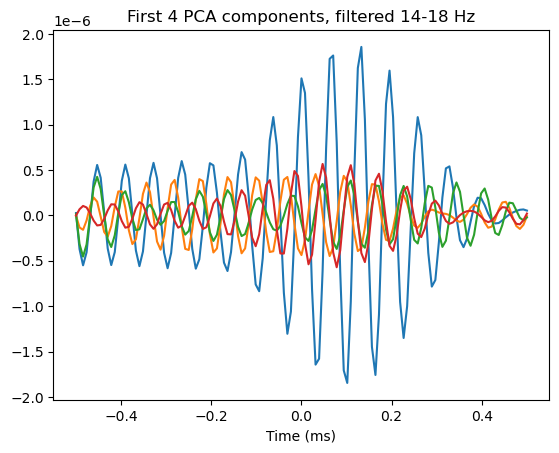

In [6]:
erp_times = create_erp_times(-0.5, 0.5, 128)
X_pca_mean = np.mean(X_pca, axis = 0)
for i in range(n_PCA):
    plt.plot(erp_times,X_pca_mean[i, :])

plt.title(f'First {n_PCA} PCA components, filtered {fmin}-{fmax} Hz')
plt.xlabel('Time (ms)')

In [7]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp.fit_transform(X_reconst, y)

array([[-0.62447833, -0.32830743, -0.87569355, -0.7361288 ],
       [-0.98715134, -2.42645075, -1.72592434, -0.62612816],
       [-1.26361942, -0.6169267 , -0.314857  , -1.6387531 ],
       ...,
       [ 0.32131784, -1.02806418, -1.140629  , -0.64459007],
       [-0.54886906, -1.67328909, -0.12920321, -2.07182711],
       [-0.73473443, -1.8928948 , -1.99608748, -1.22649507]])

In [13]:
eps_post = mne.read_epochs('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_01.fif')

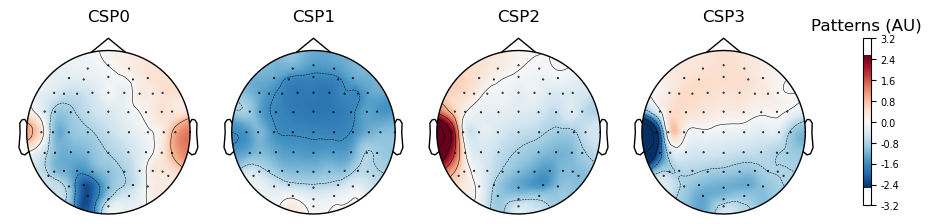

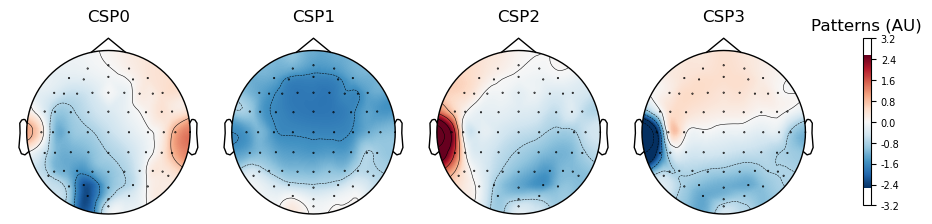

In [14]:
ch_names_64, _ = load_channels()
eeg_ch_names = ch_names_64
new_info = mne.pick_info(eps_post.info, sel=[eps_post.info['ch_names'].index(ch) for ch in eeg_ch_names])

csp.plot_patterns(new_info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Run cross-validation

In [313]:
#cross validation scoring over all freqs
#cross_val_score_freq = cross_val_score(estimator=clf, X=X_reconstructed, y=y, scoring="roc_auc", cv=cv)
#print(cross_val_score_freq)

In [49]:

#subjects_to_process = ['01', '02']

task = 'motor'
epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data_n05to05_30Hz/'

subjects_to_process = find_existing_subjects(epochs_dir)
n_subs = len(subjects_to_process)

freq_scores = {}
for freq, (fmin, fmax) in enumerate(tqdm(freq_ranges)):

    for sub in subjects_to_process:
        #load pre and post data
        ep_file_pre = os.path.join(epochs_dir, f'{task}_epochs_pre_{sub}.fif')
        ep_file_post = os.path.join(epochs_dir, f'{task}_epochs_post_{sub}.fif')

        #filter data
        X_pre, y_pre = get_xy_filtered(ep_file_pre, 1, l_freq = fmin, h_freq = fmax, method='iir', iir_params=iir_params, reject = reject_criteria)
        X_post, y_post =get_xy_filtered(ep_file_post, 2, l_freq = fmin, h_freq = fmax, method='iir', iir_params=iir_params, reject = reject_criteria)

        #get data and labels
        X = np.vstack([X_pre, X_post])
        y = np.hstack([y_pre, y_post])

        #PCA on data, project back to EEG space
        X_reconst, _ = ep_PCA(X, n_components = n_PCA)

        #cross validation
        cross_val_score_freq = np.mean(cross_val_score(estimator=clf, X=X_reconst, y=y, scoring="roc_auc", cv=cv))
        key = f'{fmin}-{fmax}Hz'

        # Initialize or append to the list
        if key in freq_scores:
            freq_scores[key].append(cross_val_score_freq)
        else:
            freq_scores[key] = [cross_val_score_freq]

freq_scores = {key:np.array(value) for key, value in freq_scores.items()}

savemat(f'freq_scores_PCA_{task}.mat', freq_scores)

  0%|          | 0/7 [00:00<?, ?it/s]

Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_

 14%|█▍        | 1/7 [02:55<17:32, 175.35s/it]

Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_

 29%|██▊       | 2/7 [05:40<14:06, 169.31s/it]

Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_

 43%|████▎     | 3/7 [08:24<11:07, 166.93s/it]

Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_

 57%|█████▋    | 4/7 [11:11<08:20, 166.92s/it]

Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_

 71%|███████▏  | 5/7 [13:55<05:32, 166.01s/it]

Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_

 86%|████████▌ | 6/7 [16:39<02:45, 165.31s/it]

Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_01.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_03.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_pre_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_post_04.fif
Bandpass filtering /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_epochs_data_n05to05_30Hz/motor_epochs_

100%|██████████| 7/7 [19:26<00:00, 166.60s/it]


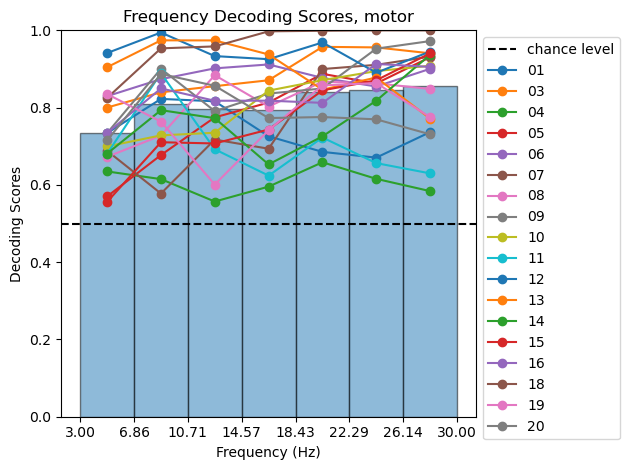

In [50]:
freq_scores_mean = np.zeros(n_freqs-1)
for i, key in enumerate(freq_scores.keys()):
    freq_scores_mean[i] = np.mean(freq_scores[key])
    

freqs_xpos = averages = (freqs[:-1] + freqs[1:]) / 2

plt.bar(freqs[:-1], freq_scores_mean, width=np.diff(freqs)[0], align="edge", edgecolor="black", alpha = 0.5)
plt.xticks(freqs)
plt.ylim([0, 1])
plt.axhline(
    0.5, color="k", linestyle="--", label="chance level"
)

#plot points for each fold (should be each subject left out eventually)
"""for i, freq in enumerate(freq_scores.keys()):
    freq_range = freq_ranges[i]
    freq_toplot = np.mean(freq_range)
    freq_xpos = [freq_toplot]* freq_scores[freq].shape[0]
    plt.scatter(freq_xpos,freq_scores[freq], color = 'black')"""

for idx in range(n_subs):
    freq_scores_idx = {key: value[idx] for key, value in freq_scores.items()}
    score = list(freq_scores_idx.values())
    plt.plot(freqs_xpos, score, 'o-', label=subjects_to_process[idx])


plt.legend(bbox_to_anchor = (1,1))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title(f"Frequency Decoding Scores, {task}")
plt.tight_layout()

In [4]:
freq_scores

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Jan  3 11:23:40 2025',
 '__version__': '1.0',
 '__globals__': [],
 '3.0-6.86Hz': array([[0.95775559, 0.68743687, 0.68641798, 0.56188017, 0.63786157,
         0.72375172, 0.68250682, 0.62603966, 0.62241449, 0.99316225,
         0.72395241, 0.97042816, 0.64043097, 0.75843817, 0.5839965 ,
         0.87632968, 0.94942602, 0.66455586, 0.77791107, 0.73276515,
         0.61724964]]),
 '6.86-10.71Hz': array([[0.97642105, 0.68704871, 0.71647511, 0.67738751, 0.70683253,
         0.7902003 , 0.56862445, 0.70874677, 0.68849001, 0.72941916,
         0.81882694, 0.96855939, 0.73343829, 0.75843632, 0.58630932,
         0.8897626 , 0.8014637 , 0.70604243, 0.68729486, 0.75501894,
         0.61747751]]),
 '10.71-14.57Hz': array([[0.96148218, 0.73180433, 0.67097665, 0.61330349, 0.73661616,
         0.68391299, 0.66085716, 0.83692208, 0.59944904, 0.67334433,
         0.7510535 , 0.94699521, 0.70800641, 0.85515474, 0.56355474,
         0

In [3]:
freq_scores = loadmat('freq_scores_PCA_listen.mat')
freq_scores_df = pd.DataFrame(freq_scores)
freq_scores_ranked = freq_scores_df.rank(axis = 1, ascending = False)

ValueError: Per-column arrays must each be 1-dimensional

In [2]:

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(freq_scores_ranked, annot=True, fmt=".0f", cmap="coolwarm", cbar_kws={"label": "Rank"})
plt.title(f"Frequency Decoding Score Rankings, {task}, (1 = best)")
plt.ylabel('Subject')
plt.xlabel('Frequency')

NameError: name 'freq_scores_ranked' is not defined

<Figure size 1000x600 with 0 Axes>

In [255]:
"""
#PCA
n_PCA = 4
pca = UnsupervisedSpatialFilter(PCA(n_PCA), average=False)
X_pca = pca.fit_transform(X)


#reconstruct PCA into EEG channel space
#X_reconstructed = np.empty_like(X)  # Placeholder for reconstructed data
X_reconstructed = pca.inverse_transform(X_pca)
"""

Visualize PCA components

In [250]:
"""pos = load_ep_info()
comp_1 = pca.estimator.components_[3]
mne.viz.plot_topomap(comp_1, pos)"""


ModuleNotFoundError: No module named 'mne.io.meas_info'

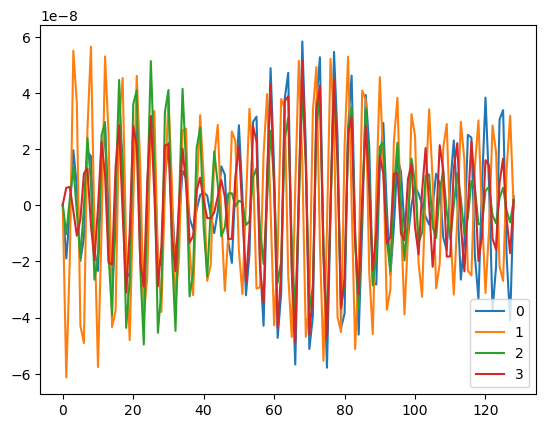

In [55]:
pca_mean = np.mean(X, axis = 0)

for i in range(n_PCA):
    plt.plot(pca_mean[i, :], label = i)

plt.legend()

In [138]:
csp = CSP(n_components=4, reg=None, log=True, transform_into='average_power')

# Fit CSP using labels (e.g., y contains 0/1 for two classes)
csp.fit(X, y)

# Transform the data to extract CSP features
csp_features = csp.transform(X)  # Shape: (n_epochs, n_components)


In [142]:
csp_features.shape

(656, 4)

### Visualize CSP components

In [139]:
ch_names_64, _ = load_channels()
eeg_ch_names = ch_names_64
new_info = mne.pick_info(eps_post.info, sel=[eps_post.info['ch_names'].index(ch) for ch in eeg_ch_names])
csp.plot_patterns(new_info, ch_type="eeg", units="Patterns (AU)", size=1.5)

ValueError: Info (64) and data (4) must have same number of channels.